In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from urllib.request import Request
import matplotlib.pyplot as plt
import re

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.Download datasets

### Rating-Num Votes Dataset

In [ ]:
#Load our data base
imdb = pd.read_csv('/content/drive/MyDrive/WebAnalyticsFinalProject/data.tsv', sep='\t')
imdb.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1923
1,tt0000002,5.8,260
2,tt0000003,6.5,1732
3,tt0000004,5.6,174
4,tt0000005,6.2,2544


### Data Features (Imdb title)

In [ ]:
imdb_title = pd.read_csv('/content/drive/MyDrive/WebAnalyticsFinalProject/data_title.tsv', sep='\t')
imdb_title.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


We just take the same info as the ids that we have scraped. We place a threshold for the number of votes and only take into account the movies.

In [ ]:
ids_movies = list(imdb_title[imdb_title.titleType == 'movie'].tconst.values)

#Decidir con que datos nos quedamos 
data = imdb[imdb.tconst.isin(ids_movies)]
data = data[data.numVotes > 200]
data = data.iloc[-22000:,:]
data['Id'] = data['tconst']
data.drop('tconst', axis=1, inplace=True)
#data['ratingByNumVotes'] = data['averageRating'].values / data['numVotes'].values
#data['numVotesNorm'] = data['numVotes'].values / data['numVotes'].values.sum() #Plantear usar el maximo
#data['ratingNorm'] = data['averageRating'].values * data['numVotesNorm'].values
data

,averageRating,numVotes,Id
839770,5.6,421,tt2246909
839773,6.0,1513,tt2246924
839784,6.9,1987,tt2246953
839816,3.7,585,tt2247101
839819,7.2,242,tt2247111
...,...,...,...
1243903,5.4,270,tt9914192
1243905,4.3,217,tt9914286
1243969,3.6,238,tt9916190
1243976,5.8,1370,tt9916270


In [ ]:
data2 = pd.merge(imdb_title, data, left_on='tconst', right_on='Id')
#data = data.merge(imdb_title, how='left', left_on=['Id'], right_on=['tconst'])[['averageRating', 'numVotes', 'Id', 'isAdult']]
data2.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Id
0,tt2246909,movie,Pauline détective,Pauline détective,0,2012,\N,101,"Comedy,Crime,Mystery",5.6,421,tt2246909
1,tt2246924,movie,Tricked: The Documentary,Tricked: The Documentary,0,2013,\N,73,"Crime,Documentary",6.0,1513,tt2246924
2,tt2246953,movie,Rent-a-Cat,Rentaneko,0,2012,\N,110,"Comedy,Drama",6.9,1987,tt2246953
3,tt2247101,movie,Undertaker,Sôginin - andâteikâ,0,2012,\N,64,Horror,3.7,585,tt2247101
4,tt2247111,movie,Versicherungsvertreter - Die erstaunliche Karr...,Versicherungsvertreter - Die erstaunliche Karr...,0,2011,\N,79,Documentary,7.2,242,tt2247111


### ** Scrapping (don't run this cells)


In [ ]:
'''
ids = [id for id in data.Id]

titles = []
years = []
durations = [] 
directors = []
actors_list = []
genres_list = []
ids_list = []
budgets = []
languages = []
months = []

'''

'\nids = [id for id in data.Id]\n\ntitles = []\nyears = []\ndurations = [] \ndirectors = []\nactors_list = []\ngenres_list = []\nids_list = []\n'

In [ ]:
'''
for i in ids[:-22000]:
    cond = True
    web_url = f"https://www.imdb.com/title/{i}"
    
    hdr = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    page = requests.get(web_url,headers=hdr)
    soup = BeautifulSoup(page.content, "html.parser")
    
    header = soup.find('div', class_ = "sc-80d4314-0 fjPRnj")
    
    #TITLE
    try: title = header.find('h1').text
    except: title = None

    #YEAR
    head_list = header.find("li")
    year = head_list.text


    titles.append(title)
    years.append(year[0:4])

    #DURATION
    try: 
        duration = head_list.find_next_sibling().find_next_sibling().text
    except:
        try: duration = head_list.find_next_sibling().text
        except: duration = None

    durations.append(duration)

    #DIRECTOR
    try : 
        director_scrap = soup.find("div", attrs={'data-testid':"title-pc-wide-screen"}).find_all("a")
        director = director_scrap[0].text
    except: director  = None

    directors.append(director)


    #ACTORS
    try :
        actors_scrap = soup.find("div",class_="sc-bfec09a1-5 dGCmsL")
        actors = [actors_scrap.find("img")['alt']]
        c = True

        while c:
            try:
                actor = actors_scrap.find_next_sibling().find("img")['alt']
                actors_scrap = actors_scrap.find_next_sibling()
                actors.append(actor)
            except:
                c=False 
    except:
        actors = None
    actors_list.append(actors)

    #GENRES
    try : genres_scrap = soup.find("div", attrs={'data-testid':"genres"}).find_all("a")
    except:  genres_scrap = []

    genres = []
    for a in genres_scrap:
        genres.append(a.find("span").text)

    genres_list.append(genres)
    
    #BUDGET
    try: 
        budget = soup.find("div", attrs={'data-testid':"title-boxoffice-section"}).find('label').text[1:].split(' ')[0]
        budget = int(budget.replace(',', ''))
    except:
        budget = None
    budgets.append(budget)

    #MONTH
    try:
        details1 = soup.find("div", attrs={'data-testid':"title-details-section"})
        month = details1.find_all("a")[1].text.split(' ')[0]
    except:
        month = None
    months.append(month)
    
    #LANGUAGE
    try:
        details2 = soup.find("li", attrs={'data-testid':"title-details-languages"})
        language = details2.find("a").text
    except:
        language = None
    languages.append(language)
    ids_list.append(i)
'''

'\n#SOLO PARA 2000\nfor i in ids[2000:4000]:\n    cond = True\n    web_url = f"https://www.imdb.com/title/{i}"\n    \n    hdr = {\'User-Agent\': \'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36\'}\n    page = requests.get(web_url,headers=hdr)\n    soup = BeautifulSoup(page.content, "html.parser")\n    \n    header = soup.find(\'div\', class_ = "sc-80d4314-0 fjPRnj")\n    #TITLE\n    try: title = header.find(\'h1\').text\n    except: title = None\n\n    #YEAR\n    head_list = header.find("li")\n    year = head_list.text\n\n\n    titles.append(title)\n    years.append(year[0:4])\n\n    #DURATION\n    try: \n        duration = head_list.find_next_sibling().find_next_sibling().text\n    except:\n        try: duration = head_list.find_next_sibling().text\n        except: duration = None\n\n    durations.append(duration)\n\n    #DIRECTOR\n    try : \n        director_scrap = soup.find("div", attrs={\'data-testid\':"tit

In [ ]:
'''
imdb_movies = pd.DataFrame()
imdb_movies['Id'] = ids_list
imdb_movies['Title'] = titles 
imdb_movies['Year'] = years 
imdb_movies['Duration'] = durations 
imdb_movies['Director'] = directors 
imdb_movies['Actors'] = actors_list 
imdb_movies['Genres'] = genres_list
imdb_movies['Budgets'] = budgets 
imdb_movies['Languages'] = languages
imdb_movies['Months'] = months
'''

"\nimdb_movies = pd.DataFrame()\nimdb_movies['Id'] = ids_list\nimdb_movies['Title'] = titles \nimdb_movies['Year'] = years \nimdb_movies['Duration'] = durations \nimdb_movies['Director'] = directors \nimdb_movies['Actors'] = actors_list \nimdb_movies['Genres'] = genres_list\n"

In [ ]:
#imdb_movies.to_excel('IMDB.xlsx', encoding = 'UTF-8')

### Download Scraped Dataset

In [ ]:
imdb_movies = pd.read_excel('/content/drive/MyDrive/WebAnalyticsFinalProject/IMDB.xlsx')
imdb_movies.drop('Unnamed: 0', axis=1, inplace=True)
imdb_movies.drop('Unnamed: 0.1', axis=1, inplace=True)
imdb_movies

,Id,Title,Year,Duration,Director,Actors,Genres,Budgets,Languages,Months
0,tt8674506,There Are No Fakes,2019,1h 53m,Jamie Kastner,NaN,"['Documentary', 'Biography', 'Crime']",NaN,English,April
1,tt8675288,Intrépido,2020,1h 29m,Cory Edwards,"['Yara Shahidi', 'Miles Robbins', 'Miguel', 'J...","['Animation', 'Comedy', 'Family']",NaN,Spanish,July
2,tt8675532,The Fear Footage,2018,1h 11m,Ricky Umberger,NaN,['Horror'],NaN,English,July
3,tt8676044,Her Sey Seninle Güzel,2018,1h 48m,Cem Karci,['Burcu Biricik'],"['Comedy', 'Romance']",332480.0,Turkish,November
4,tt8676426,The Fable,2019,2h 3m,Kan Eguchi,"[""Jun'ichi Okada"", 'Fumino Kimura', 'Mizuki Ya...","['Action', 'Comedy']",15183043.0,Japanese,June
...,...,...,...,...,...,...,...,...,...,...
21995,tt2533024,Unidentified,2013,1h 30m,Jason Richard Miller,"['Parry Shen', 'Colton Dunn', 'Eddie Mui', 'Er...","['Comedy', 'Horror', 'Sci-Fi']",NaN,English,November
21996,tt2534634,La clase de esgrima,2015,1h 39m,Klaus Härö,['Märt Avandi'],"['Biography', 'Drama', 'History']",1605000.0,Estonian,July
21997,tt2534642,Captain Morten and the Spider Queen,2018,1h 19m,Kaspar Jancis,NaN,"['Animation', 'Family']",3000000.0,English,August
21998,tt2534648,Kertu,2013,1h 38m,Ilmar Raag,NaN,"['Drama', 'Romance']",640000.0,Estonian,October


In [ ]:
#Para comprobar si hay duplicados
import numpy as np
duplicates = []
for col in range(imdb_movies.shape[1]):
    contents = imdb_movies.iloc[:, col]
    
    for comp in range(col + 1, imdb_movies.shape[1]):
        if contents.equals(imdb_movies.iloc[:, comp]):
            duplicates.append(comp)
duplicates = np.unique(duplicates).tolist()
duplicates

[]

In [ ]:
print(imdb_movies.isna().sum())

Id              0
Title           0
Year            0
Duration      151
Director        5
Actors       5145
Genres          0
Budgets      8952
Languages     358
Months          0
dtype: int64


In [ ]:
#Remove the NaN values before applying the split function
imdb_movies.dropna(inplace=True)
imdb_movies = imdb_movies.reset_index(drop=True)

## 2.Tranformations for the scraped dataset

### YEAR: Function to convert the year variable to integer

In [ ]:
imdb_movies.Year.unique()

array(['2018', '2019', '2021', '2020', '2016', '2022', '2017', '1988',
       '1975', 'TV M', '2014', '2015', '2002', '1974', '1997', '2008',
       '2011', '2013', '2012', '2005', '1970', '2007', '2003', '1998',
       '2006', '1982', 2014, 2013, 2015, 2016, 2017, 2012, 2019, 2018,
       2020, 2008, 2011, 2007, 2010, 2021, 2022, 2006, 2009], dtype=object)

In [ ]:
imdb_movies = imdb_movies[imdb_movies['Year'] != 'TV M']
imdb_movies['Year'] = pd.to_numeric(imdb_movies['Year'])
imdb_movies = imdb_movies[imdb_movies['Year']>=2000]

imdb_movies.Year.unique()

<ipython-input-179-fa9f4edd805f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_movies['Year'] = pd.to_numeric(imdb_movies['Year'])


array([2018, 2019, 2021, 2020, 2016, 2022, 2017, 2014, 2015, 2002, 2008,
       2011, 2013, 2012, 2005, 2007, 2003, 2006, 2010, 2009])

### BUDGETS: Analysis of the budgets

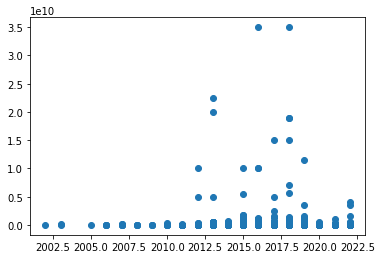

In [ ]:
plt.scatter(imdb_movies.Year,imdb_movies.Budgets)

In [ ]:
#Quitamos los que tienen budgets mayores que ese threshold que es el de endgame
imdb_movies = imdb_movies[imdb_movies.Budgets < 0.036*1e10] #360.000.000

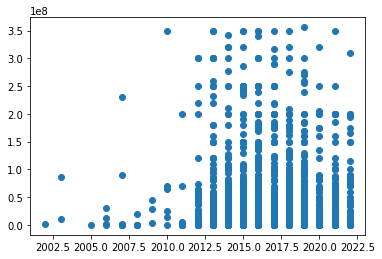

In [ ]:
plt.scatter(imdb_movies.Year,imdb_movies.Budgets)

### MONTHS: Function to convert months to a number


In [ ]:
imdb_movies.Months.unique()

array(['November', 'June', 'February', 'August', '2021', 'May', 'January',
       'December', 'October', 'September', 'March', 'April', 'July',
       '2020', '2022', '2018', '2017', 'English', '2016', '2019', '2013',
       '2015', 'Official', '2014', '2008', 'Tamil'], dtype=object)

In [ ]:
months_dic = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

In [ ]:
def returnMonthInt(month):
  try: month_int = months_dic[f'{month}']
  except:
    month_int = np.nan
  return month_int

imdb_movies['MonthCat'] = imdb_movies['Months'].apply(lambda x: returnMonthInt(x))

In [ ]:
print(imdb_movies.isna().sum())

Id            0
Title         0
Year          0
Duration      0
Director      0
Actors        0
Genres        0
Budgets       0
Languages     0
Months        0
MonthCat     63
dtype: int64


In [ ]:
imdb_movies.dropna(inplace=True)

### DURATION: Function to convert the duration variable to minutes

In [ ]:
def split_duration(duration):
  if 'h' in duration or 'm' in duration:
    if 'h' in duration:
      hours = duration.split('h')[0]
      
      hours = int(hours)

      rest = duration.split('h')[1]
      if 'm' in rest:
        min = rest[1:].split('m')[0]
        min = int(min)

        time = hours*60 + min
      else:
        time = hours*60
    else:
      min = duration.split('m')[0]
      min = int(min)

      time = min
  else:
    time=np.nan

  return time
imdb_movies['Duration'] = imdb_movies['Duration'].apply(lambda x: split_duration(x))

In [ ]:
print(imdb_movies.isna().sum())

Id           0
Title        0
Year         0
Duration     0
Director     0
Actors       0
Genres       0
Budgets      0
Languages    0
Months       0
MonthCat     0
dtype: int64


In [ ]:
imdb_movies.dropna(inplace=True)

In [ ]:
imdb_movies['Duration'].values

array([108, 123,  99, ...,  87,  87,  99])

In [ ]:
#Quitamos los que tienen duration mayores que ese threshold que es 300 mins
index = list(imdb_movies[imdb_movies['Duration']>=300].index)
imdb_movies = imdb_movies.drop(index, axis = 0)
imdb_movies.head()

,Id,Title,Year,Duration,Director,Actors,Genres,Budgets,Languages,Months,MonthCat
0,tt8676044,Her Sey Seninle Güzel,2018,108,Cem Karci,['Burcu Biricik'],"['Comedy', 'Romance']",332480.0,Turkish,November,11.0
1,tt8676426,The Fable,2019,123,Kan Eguchi,"[""Jun'ichi Okada"", 'Fumino Kimura', 'Mizuki Ya...","['Action', 'Comedy']",15183043.0,Japanese,June,6.0
2,tt8688634,Manhattan sin salida,2019,99,Brian Kirk,"['Chadwick Boseman', 'Sienna Miller', 'J.K. Si...","['Action', 'Crime', 'Drama']",33000000.0,English,February,2.0
3,tt8688912,Chi La Sow,2018,135,Rahul Ravindran,"['Sushanth', 'Ruhani Sharma', 'Vennela Kishore...","['Comedy', 'Romance']",4551.0,Telugu,August,8.0
5,tt8689644,Hearts and Bones,2019,111,Ben Lawrence,['Hugo Weaving'],['Drama'],94957.0,English,May,5.0


In [ ]:
list(imdb_movies[imdb_movies['Duration']>=300].index)

[]

### LANGUAGES: Convert the languages to categorical

In [ ]:
languages =imdb_movies.Languages.unique()
df_languages=pd.DataFrame()
df_languages['language']=languages

for i in range(0,len(languages)):  
    df_languages['contador']=0
    df_languages['porcentaje']=0

df_languages

,language,contador,porcentaje
0,Turkish,0,0
1,Japanese,0,0
2,English,0,0
3,Telugu,0,0
4,French,0,0
...,...,...,...
86,Tswana,0,0
87,Maori,0,0
88,Guarani,0,0
89,Kyrgyz,0,0


In [ ]:
def total_lang(base, tabla_conteo):
  for idioma in range(len(base.Languages)):
    for cont in range(len(tabla_conteo.contador)):
      if base.Languages[idioma] == tabla_conteo.language[cont]:
        tabla_conteo.contador[cont] += 1 

In [ ]:
imdb_movies = imdb_movies.reset_index(drop=True)
df_languages = df_languages.reset_index(drop=True)

In [ ]:
total_lang(imdb_movies, df_languages)

<ipython-input-205-af3251df49ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabla_conteo.contador[cont] += 1


In [ ]:
def porcentaje(tabla_porcentaje):
  for language in range(len(tabla_porcentaje.porcentaje)):
    total = sum(tabla_porcentaje.contador)
    tabla_porcentaje.porcentaje[language] = (tabla_porcentaje.contador[language]/total)*100

In [ ]:
porcentaje(df_languages)

<ipython-input-208-ffe9f48d0822>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabla_porcentaje.porcentaje[language] = (tabla_porcentaje.contador[language]/total)*100


In [ ]:
df_importantes = df_languages[df_languages.porcentaje >= 3]
df_importantes 

,language,contador,porcentaje
1,Japanese,349,3
2,English,4536,45
4,French,759,7
7,Hindi,446,4
12,Spanish,495,4
18,Italian,308,3


In [ ]:
imdb_movies = imdb_movies.assign(Group_Language = " ")

In [ ]:
def tipo_lenguaje(base, contador):
  tb_secundarias = contador[(contador.porcentaje < 3) & (contador.porcentaje >= 1)] 
  lista_secundarias = list(tb_secundarias.language)

  tb_otros = contador[contador.porcentaje == 0] 
  lista_otros = list(tb_otros.language)

  for lenguaje in range(len(base)):
    if base.Languages[lenguaje] in lista_secundarias:
      base.Group_Language[lenguaje] = "Secundarias"
      
    elif base.Languages[lenguaje] in lista_otros:
      base.Group_Language[lenguaje] = "Otros"

    else:
      base.Group_Language[lenguaje] = base.Languages[lenguaje]

In [ ]:
df_languages[(df_languages.porcentaje < 3) & (df_languages.porcentaje >= 1)] 

,language,contador,porcentaje
0,Turkish,237,2
3,Telugu,158,1
5,Malayalam,192,1
6,Portuguese,106,1
8,Polish,114,1
9,Korean,284,2
11,German,227,2
14,Russian,181,1
15,Mandarin,233,2
27,Tamil,226,2


In [ ]:
df_languages[(df_languages.porcentaje < 1) ] 

,language,contador,porcentaje
10,Serbian,23,0
13,Hungarian,17,0
16,Norwegian,36,0
17,Danish,40,0
19,Tagalog,24,0
...,...,...,...
86,Tswana,1,0
87,Maori,1,0
88,Guarani,1,0
89,Kyrgyz,1,0


In [ ]:
tipo_lenguaje(imdb_movies, df_languages)

<ipython-input-213-1fd5ddbeba5c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base.Group_Language[lenguaje] = "Secundarias"
<ipython-input-213-1fd5ddbeba5c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base.Group_Language[lenguaje] = base.Languages[lenguaje]
<ipython-input-213-1fd5ddbeba5c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base.Group_Language[lenguaje] = "Otros"


In [ ]:
imdb_movies.Group_Language.unique()

array(['Secundarias', 'Japanese', 'English', 'French', 'Hindi', 'Otros',
       'Spanish', 'Italian'], dtype=object)

In [ ]:
languages_cat_dic = {'Japanese':0, 'English':1, 'French':2, 'Hindi':3, 'Spanish':4, 'Italian':5, 'Secundarias':6, 'Otros':7}

In [ ]:
def returnLanguage(lang):
  f = languages_cat_dic[f'{lang}']
  return f
imdb_movies['LanguageCat'] = imdb_movies['Group_Language'].apply(lambda x: returnLanguage(x))

In [ ]:
imdb_movies.head()

,Id,Title,Year,Duration,Director,Actors,Genres,Budgets,Languages,Months,MonthCat,Group_Language,LanguageCat
0,tt8676044,Her Sey Seninle Güzel,2018,108,Cem Karci,['Burcu Biricik'],"['Comedy', 'Romance']",332480.0,Turkish,November,11.0,Secundarias,6
1,tt8676426,The Fable,2019,123,Kan Eguchi,"[""Jun'ichi Okada"", 'Fumino Kimura', 'Mizuki Ya...","['Action', 'Comedy']",15183043.0,Japanese,June,6.0,Japanese,0
2,tt8688634,Manhattan sin salida,2019,99,Brian Kirk,"['Chadwick Boseman', 'Sienna Miller', 'J.K. Si...","['Action', 'Crime', 'Drama']",33000000.0,English,February,2.0,English,1
3,tt8688912,Chi La Sow,2018,135,Rahul Ravindran,"['Sushanth', 'Ruhani Sharma', 'Vennela Kishore...","['Comedy', 'Romance']",4551.0,Telugu,August,8.0,Secundarias,6
4,tt8689644,Hearts and Bones,2019,111,Ben Lawrence,['Hugo Weaving'],['Drama'],94957.0,English,May,5.0,English,1


### GENRES: Funcition to convert genres in One Hot Encoding

In [ ]:
imdb_movies['FantasySciFi'] = 0*len(imdb_movies)
imdb_movies['Animation'] = 0*len(imdb_movies)
imdb_movies['Comedy'] = 0*len(imdb_movies)
imdb_movies['Family'] = 0*len(imdb_movies)
imdb_movies['Romance'] = 0*len(imdb_movies)
imdb_movies['ActionWarAdventureWestern'] = 0*len(imdb_movies)
imdb_movies['CrimeHorrorMisteryThriller'] = 0*len(imdb_movies)
imdb_movies['HistoryDocumentaryBiography'] = 0*len(imdb_movies)
imdb_movies['MusicalMusic'] = 0*len(imdb_movies)
imdb_movies['SportNews'] = 0*len(imdb_movies)
imdb_movies['Drama'] = 0*len(imdb_movies)
imdb_movies['RealityTV'] = 0*len(imdb_movies)

In [ ]:
def cluster_genre(data):
  for num in (list(data.Genres.index)):

    if 'Fantasy' in data.Genres[num] or 'SciFi' in data.Genres[num]:
      data.FantasySciFi[num] = 1
    
    if 'Animation' in data.Genres[num]:
      data.Animation[num] = 1

    if 'Comedy' in data.Genres[num]:
      data.Comedy[num] = 1

    if 'Family' in data.Genres[num]:
      data.Family[num] = 1

    if 'Romance' in data.Genres[num]:
      data.Romance[num] = 1

    if 'Action' in data.Genres[num] or 'War' in data.Genres[num] or 'Adventure' in data.Genres[num] or 'Western' in data.Genres[num]:
      data.ActionWarAdventureWestern[num] = 1

    if 'Crime' in data.Genres[num] or 'Horror' in data.Genres[num] or 'Mistery' in data.Genres[num] or 'Thriller' in data.Genres[num]:
      data.CrimeHorrorMisteryThriller[num] = 1

    if 'History' in data.Genres[num] or 'Documentary' in data.Genres[num] or 'Biography' in data.Genres[num]:
      data.HistoryDocumentaryBiography[num] = 1

    if 'Musical' in data.Genres[num] or 'Music' in data.Genres[num]:
      data.MusicalMusic[num] = 1

    if 'Sport' in data.Genres[num] or 'News' in data.Genres[num]:
      data.SportNews[num] = 1

    if 'Drama' in data.Genres[num]:
      data.Drama[num] = 1
    
    if 'RealityTV' in data.Genres[num]:
      data.RealityTV[num] = 1
    
  return data

In [ ]:
imdb_movies = cluster_genre(imdb_movies)
imdb_movies.head()

<ipython-input-226-db00c61c38f2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Comedy[num] = 1
<ipython-input-226-db00c61c38f2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Romance[num] = 1
<ipython-input-226-db00c61c38f2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ActionWarAdventureWestern[num] = 1
<ipython-input-226-db00c61c38f2>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,Id,Title,Year,Duration,Director,Actors,Genres,Budgets,Languages,Months,...,Comedy,Family,Romance,ActionWarAdventureWestern,CrimeHorrorMisteryThriller,HistoryDocumentaryBiography,MusicalMusic,SportNews,Drama,RealityTV
0,tt8676044,Her Sey Seninle Güzel,2018,108,Cem Karci,['Burcu Biricik'],"['Comedy', 'Romance']",332480.0,Turkish,November,...,1,0,1,0,0,0,0,0,0,0
1,tt8676426,The Fable,2019,123,Kan Eguchi,"[""Jun'ichi Okada"", 'Fumino Kimura', 'Mizuki Ya...","['Action', 'Comedy']",15183043.0,Japanese,June,...,1,0,0,1,0,0,0,0,0,0
2,tt8688634,Manhattan sin salida,2019,99,Brian Kirk,"['Chadwick Boseman', 'Sienna Miller', 'J.K. Si...","['Action', 'Crime', 'Drama']",33000000.0,English,February,...,0,0,0,1,1,0,0,0,1,0
3,tt8688912,Chi La Sow,2018,135,Rahul Ravindran,"['Sushanth', 'Ruhani Sharma', 'Vennela Kishore...","['Comedy', 'Romance']",4551.0,Telugu,August,...,1,0,1,0,0,0,0,0,0,0
4,tt8689644,Hearts and Bones,2019,111,Ben Lawrence,['Hugo Weaving'],['Drama'],94957.0,English,May,...,0,0,0,0,0,0,0,0,1,0


### ACTORS AND DIRECTOR: Analyze if they have a famous cast or director

#### Merge both datasets (new_data)

In [ ]:
new_data = pd.merge(imdb_movies, data, on='Id', how='left')
new_data.head()

,Id,Title,Year,Duration,Director,Actors,Genres,Budgets,Languages,Months,...,Romance,ActionWarAdventureWestern,CrimeHorrorMisteryThriller,HistoryDocumentaryBiography,MusicalMusic,SportNews,Drama,RealityTV,averageRating,numVotes
0,tt8676044,Her Sey Seninle Güzel,2018,108,Cem Karci,['Burcu Biricik'],"['Comedy', 'Romance']",332480.0,Turkish,November,...,1,0,0,0,0,0,0,0,3.7,531
1,tt8676426,The Fable,2019,123,Kan Eguchi,"[""Jun'ichi Okada"", 'Fumino Kimura', 'Mizuki Ya...","['Action', 'Comedy']",15183043.0,Japanese,June,...,0,1,0,0,0,0,0,0,6.5,2068
2,tt8688634,Manhattan sin salida,2019,99,Brian Kirk,"['Chadwick Boseman', 'Sienna Miller', 'J.K. Si...","['Action', 'Crime', 'Drama']",33000000.0,English,February,...,0,1,1,0,0,0,1,0,6.6,67580
3,tt8688912,Chi La Sow,2018,135,Rahul Ravindran,"['Sushanth', 'Ruhani Sharma', 'Vennela Kishore...","['Comedy', 'Romance']",4551.0,Telugu,August,...,1,0,0,0,0,0,0,0,7.7,1850
4,tt8689644,Hearts and Bones,2019,111,Ben Lawrence,['Hugo Weaving'],['Drama'],94957.0,English,May,...,0,0,0,0,0,0,1,0,6.6,645


#### Function to convert actors to array

In [ ]:
def text_to_list(lista):
  actor_list = []
  for j in range(len(lista)):
    a1 = lista[j].split(", ")
    a2 = []
    for i in range(len(a1)):
      if "['" in a1[i] and "']" in a1[i]:
        string = a1[i][2:-2]
        new_string = re.sub(r"[^a-zA-Z0-9]","",string)
        a2.append(new_string)
      else:
        if "['" in a1[i] or '["' in a1[i]:
          string = a1[i][2:-1]
          new_string = re.sub(r"[^a-zA-Z0-9]","",string)
          a2.append(new_string)
        elif "']" in a1[i] or '"]' in a1[i]:
          string = a1[i][1:-2]
          new_string = re.sub(r"[^a-zA-Z0-9]","",string)
          a2.append(new_string)
        else:
          b = a1[i][1:-1]
          if "'" in b:
            c = b.split("'")
            b = c[0]+c[1]
          new_string = re.sub(r"[^a-zA-Z0-9]","",b)
          a2.append(new_string)
      
    actor_list.append(a2)
  return actor_list

In [ ]:
new_data['Actors'] = text_to_list(list(new_data['Actors']))
new_data['Genres'] = text_to_list(list(new_data['Genres']))

In [ ]:
print(type(new_data.Actors.values[0]))
print(type(new_data.Genres.values[0]))

<class 'list'>
<class 'list'>


In [ ]:
new_data.Director = new_data.Director.apply(lambda x: re.sub(r"[^a-zA-Z0-9]","",x))
new_data.Director.values

array(['CemKarci', 'KanEguchi', 'BrianKirk', ..., 'BradOsborne',
       'RickRowley', 'KlausHr'], dtype=object)

#### Populars directors and actors

In [ ]:
def get_uniques(values):
  uniques = []
  total = []
  for lista in values:
    for item in lista:
      if item not in uniques:
        uniques.append(item)
      total.append(item)

  return uniques, total

In [ ]:
unique_actors = get_uniques(new_data['Actors'])[0]
print('Unique actors: ', len(get_uniques(new_data['Actors'])[0]))
print('Total actors: ', len(get_uniques(new_data['Actors'])[1]))

unique_genres = get_uniques(new_data['Genres'])[0]
print('Unique genres: ', len(get_uniques(new_data['Genres'])[0]))
print('Total genres: ', len(get_uniques(new_data['Genres'])[1]))

unique_directors = list(new_data.Director.unique())
print('Unique directors: ',len(unique_directors))
print('Total directors: ',len(new_data.Director))

Unique actors:  29697
Total actors:  59583
Unique genres:  23
Total genres:  21780
Unique directors:  7423
Total directors:  10078


In [ ]:
def getActorDirectorCount(unique, tipo):
  actors = []
  a_counts = []
  r_counts = []

  for a in unique:
    a_count = 0
    r_count = 0 

    for m in range(len(new_data.Actors)):

      if tipo =='director':
        if a == new_data.Director.iloc[m]:
          a_count += 1
          r_count += new_data.averageRating.values[m]
      else:
        if a in new_data.Actors.values[m]:
          a_count += 1
          r_count += new_data.averageRating.values[m]

    actors.append(a)
    a_counts.append(a_count)
    r_counts.append(r_count/a_count)

  return actors, a_counts, r_counts

In [ ]:
actors, a_counts, r_a_counts = getActorDirectorCount(unique_actors, "actors")

In [ ]:
actors_count = pd.DataFrame()
actors_count['Actor']= actors
actors_count['Count']= a_counts
actors_count['MeanRating']= r_a_counts
actors_count = actors_count.sort_values(['MeanRating'], ascending=False)

popular_actors = list(actors_count.Actor.values)[0:1000]
actors_count.head(10)

,Actor,Count,MeanRating
6348,ResulPookutty,1,9.2
19310,HarryAttwell,1,9.1
19311,SamanthaColley,1,9.1
19313,JackEllis,1,9.1
19314,AnnFirbank,1,9.1
19315,WilliamGaunt,1,9.1
12322,Chiranjit,1,9.0
25321,MarcoCruz,1,9.0
13592,DanielKeith,1,8.9
13593,KathySearle,1,8.9


In [ ]:
def getPopular(popular_actors):
  popular_actors_array = []
  for m in range(len(new_data.Actors)):
    pop_actors = 0
    for a in new_data.Actors.values[m]:
      if a in popular_actors:
        pop_actors += 1
    popular_actors_array.append(pop_actors)

  return popular_actors_array

In [ ]:
popular_actors_array = getPopular(popular_actors)
new_data['PopularActors'] = popular_actors_array
new_data.head()

,Id,Title,Year,Duration,Director,Actors,Genres,Budgets,Languages,Months,...,HistoryDocumentaryBiography,MusicalMusic,SportNews,Drama,RealityTV,averageRating,numVotes,PopularActors,PopularDirectors,RatingClass
0,tt8676044,Her Sey Seninle Güzel,2018,108,CemKarci,[BurcuBiricik],"[Comedy, Romance]",332480.0,Turkish,November,...,0,0,0,0,0,3.7,531,0,0,Bad
1,tt8676426,The Fable,2019,123,KanEguchi,"[JunichiOkada, FuminoKimura, MizukiYamamoto, S...","[Action, Comedy]",15183043.0,Japanese,June,...,0,0,0,0,0,6.5,2068,0,0,Good
2,tt8688634,Manhattan sin salida,2019,99,BrianKirk,"[ChadwickBoseman, SiennaMiller, JKSimmons, Ste...","[Action, Crime, Drama]",33000000.0,English,February,...,0,0,0,1,0,6.6,67580,0,0,Good
3,tt8688912,Chi La Sow,2018,135,RahulRavindran,"[Sushanth, RuhaniSharma, VennelaKishore, Anura...","[Comedy, Romance]",4551.0,Telugu,August,...,0,0,0,0,0,7.7,1850,3,0,Very Good
4,tt8689644,Hearts and Bones,2019,111,BenLawrence,[HugoWeaving],[Drama],94957.0,English,May,...,0,0,0,1,0,6.6,645,0,0,Good


In [ ]:
directors, d_counts, r_d_counts = getActorDirectorCount(unique_directors, 'director')

In [ ]:
directors_count = pd.DataFrame()
directors_count['Director']= directors
directors_count['Count']= d_counts
directors_count['MeanRating']= r_d_counts
directors_count = directors_count.sort_values(['MeanRating'], ascending=False)

popular_directors = list(directors_count.Director.values)[0:500]
directors_count.head(10)

,Director,Count,MeanRating
1291,ResulPookutty,1,9.2
4575,YalFarber,1,9.1
2790,AniketChattopadhyay,1,9.0
2271,KiranrajK,1,8.9
3131,DanielKeith,1,8.9
644,VipulMehta,1,8.8
2185,GavinElder,1,8.8
1315,DavidBarnard,1,8.8
1600,SameerVidwans,1,8.8
32,DraganBjelogrlic,1,8.8


In [ ]:
popular_directors_array = getPopular(popular_directors)
new_data['PopularDirectors'] = popular_directors_array
new_data.head()

,Id,Title,Year,Duration,Director,Actors,Genres,Budgets,Languages,Months,...,HistoryDocumentaryBiography,MusicalMusic,SportNews,Drama,RealityTV,averageRating,numVotes,PopularActors,PopularDirectors,RatingClass
0,tt8676044,Her Sey Seninle Güzel,2018,108,CemKarci,[BurcuBiricik],"[Comedy, Romance]",332480.0,Turkish,November,...,0,0,0,0,0,3.7,531,0,0,Bad
1,tt8676426,The Fable,2019,123,KanEguchi,"[JunichiOkada, FuminoKimura, MizukiYamamoto, S...","[Action, Comedy]",15183043.0,Japanese,June,...,0,0,0,0,0,6.5,2068,0,0,Good
2,tt8688634,Manhattan sin salida,2019,99,BrianKirk,"[ChadwickBoseman, SiennaMiller, JKSimmons, Ste...","[Action, Crime, Drama]",33000000.0,English,February,...,0,0,0,1,0,6.6,67580,0,0,Good
3,tt8688912,Chi La Sow,2018,135,RahulRavindran,"[Sushanth, RuhaniSharma, VennelaKishore, Anura...","[Comedy, Romance]",4551.0,Telugu,August,...,0,0,0,0,0,7.7,1850,3,0,Very Good
4,tt8689644,Hearts and Bones,2019,111,BenLawrence,[HugoWeaving],[Drama],94957.0,English,May,...,0,0,0,1,0,6.6,645,0,0,Good


In [ ]:
"""
from google.colab import files

new_data_excel = new_data.to_excel('IMDB_DATA.xlsx', encoding = 'UTF-8')
files.download('IMDB_DATA.xlsx')
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3.Model

In [4]:
#new_data = pd.read_excel('/content/drive/MyDrive/WebAnalyticsFinalProject/IMDB_DATA8.xlsx')

In [5]:
def rating_class(val):
  
  if (val>= 0) & (val < 2.5):
    return 'Very Bad'
  elif (val>= 2.5) & (val < 5.):
    return 'Bad'
  elif (val>= 5.) & (val < 7.5):
    return 'Good'
  elif (val>= 7.5) & (val < 10):
    return 'Very Good'
    
new_data['RatingClass'] = new_data['averageRating'].apply(lambda x: rating_class(x))

In [6]:
X = new_data.loc[:,['Year', 'Duration',
       'FantasySciFi','Animation', 'Comedy', 'Family',
       'Romance', 'ActionWarAdventureWestern', 'CrimeHorrorMisteryThriller',
       'HistoryDocumentaryBiography', 'MusicalMusic', 'SportNews',
       'Drama', 'RealityTV', 'PopularActors', 'PopularDirectors', 'Budgets', 'LanguageCat','MonthCat']]
y = new_data.loc[:,'RatingClass']

### Data Augmentation

In [7]:
def class_balance(lista):
  d = {i:0 for i in set(lista)}
  for j in lista:
    d[j] += 1
  return d
class_balance(y)

{'Good': 7489, 'Very Bad': 90, 'Bad': 1733, 'Very Good': 766}

### Undersampling + Oversampling

- Undersampling: 'Good' to 4500 samples
- Oversampling

In [8]:
# transform the dataset
strategy = {'Good':4500}
undersample = NearMiss(sampling_strategy=strategy, version=1)
X_r, y_r = undersample.fit_resample(X, y)
class_balance(y_r)

{'Good': 4500, 'Very Bad': 90, 'Bad': 1733, 'Very Good': 766}

In [9]:
# transform the dataset
strategy = {'Very Good':int(788*5),'Bad':int(1744*2.5), 'Very Bad':int(92*38)}
oversample = SMOTE(sampling_strategy=strategy)
X_r2, y_r2 = oversample.fit_resample(X_r, y_r)
class_balance(y_r2)

{'Good': 4500, 'Very Bad': 3496, 'Bad': 4360, 'Very Good': 3940}

### Correlation Matrix

<ipython-input-143-5492a346bd8e>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(X_r2.corr(), dtype=np.bool))


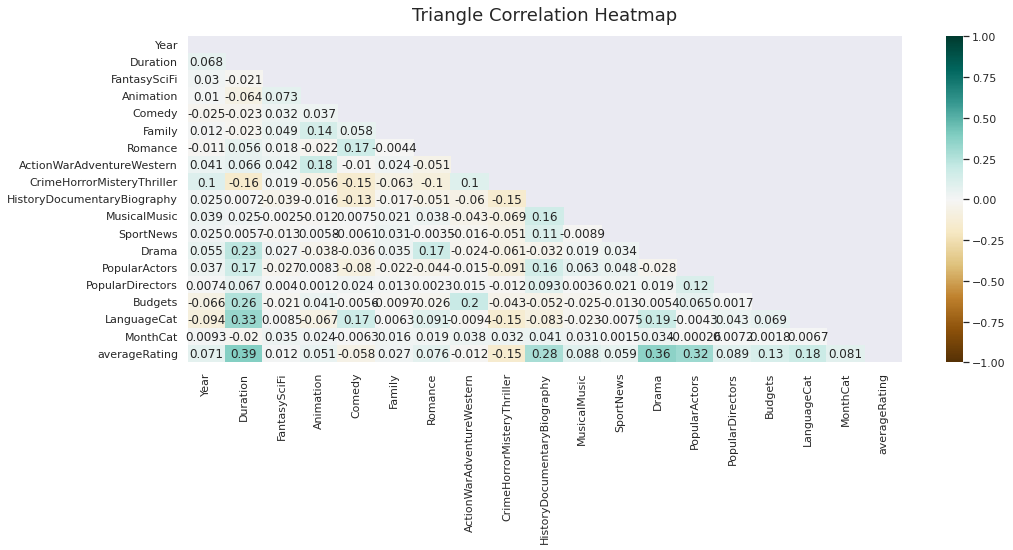

In [ ]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
X_r2.drop('RealityTV', axis=1, inplace=True)
mask = np.triu(np.ones_like(X_r2.corr(), dtype=np.bool))
heatmap = sns.heatmap(X_r2.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

### Training, Testing and Prediction 

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X_r2, y_r2, test_size=0.3, random_state=999)


pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state = 20))
])

hyperparameters = { 'classifier__n_estimators': [10, 20, 30, 50, 100, 200],
                    'classifier__max_depth': [None, 2, 4, 8, 10, 20],
                    'classifier__min_samples_leaf': [1, 2, 4, 10]
                  }
clf = GridSearchCV(pipeline, hyperparameters, cv = 5)
 
# Fit and tune model
clf.fit(train_X, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=20))]),
             param_grid={'classifier__max_depth': [None, 2, 4, 8, 10, 20],
                         'classifier__min_samples_leaf': [1, 2, 4, 10],
                         'classifier__n_estimators': [10, 20, 30, 50, 100,
                                                      200]})

In [ ]:
clf.best_params_

{'classifier__max_depth': None,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 200}

In [10]:
#MODEL
train_X, test_X, train_y, test_y = train_test_split(X_r2, y_r2, test_size=0.3, random_state=999)

clf = RandomForestClassifier(max_depth = None, min_samples_leaf= 1, n_estimators= 200, random_state=20)

clf.fit(train_X.values, train_y)
y_pred = clf.predict(test_X.values)
accuracy_score(test_y, y_pred)

0.8245039885457148

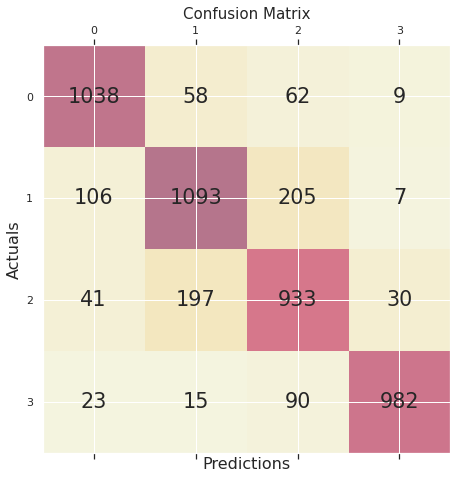

In [ ]:
# creates confusion matrix
mat_con = (confusion_matrix(test_y, y_pred, labels=['Very Good','Good', 'Bad', 'Very Bad']))

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m,y=n,s=mat_con[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

### Feature Importance

Looking at the most important features we can see that they make a lot of sense, with the Budget being the most important, with the duration or the release month. So we decided to visualize the relation of some of those variables with the ratings.

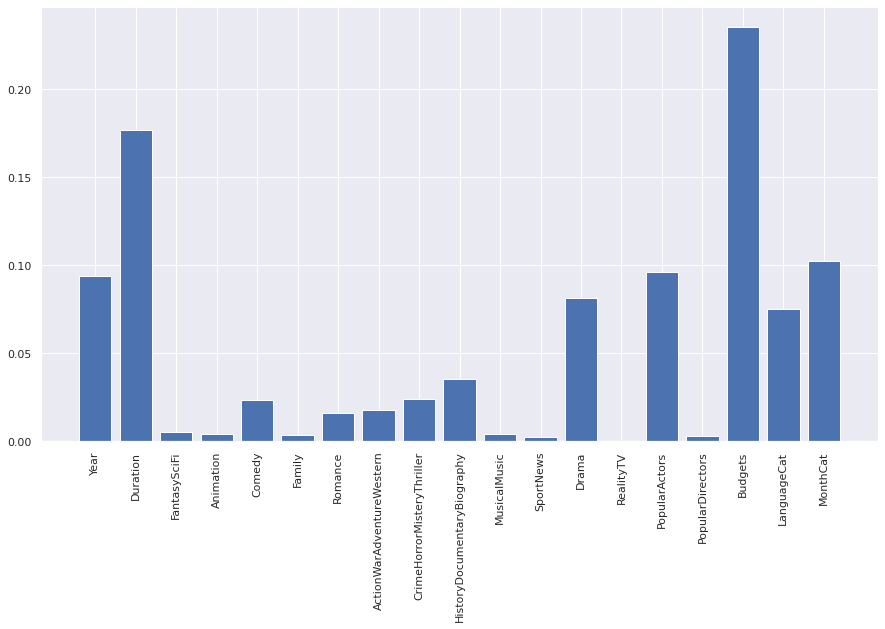

In [ ]:
importance = clf.feature_importances_
fig,ax = plt.subplots()
ax.bar(train_X.columns, importance)
ax.set_xticklabels(train_X.columns, Rotation=90)
plt.show()

#### Prediction example: 

In [ ]:
atodotren = pd.DataFrame([2022, 84, 0, 0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 979175, 4, 12]).transpose()
atodotren.columns = X.columns
clf.predict(atodotren.values)

array(['Bad'], dtype=object)

In [ ]:
avatar = pd.DataFrame([2022, 192, 1, 0, 0, 0, 0, 1,0, 0, 0, 0, 0, 0, 0, 1, 350000000, 1, 12]).transpose()
avatar.columns = X.columns
clf.predict(avatar.values)

array(['Very Good'], dtype=object)

## 4.Data Visualization

In [11]:
#Function for plotting piecharts
def count_data(data, label, genres = False):
  plot_array = []
  avg_media = []

  if genres == False:
    labels = label.unique()
  else:
    labels = label.copy()

  for i in labels:
    if genres == True:
      plot_array.append(len(data[data[i]==1]))
      avg_media.append(np.mean(data[data[i]==1]['averageRating']))
    else: 
      plot_array.append(len(data[label==i]))
      avg_media.append(np.mean(data[label==i]['averageRating']))

  plot = pd.DataFrame(plot_array)
  plot.columns = ['Count']

  if genres == False:
    plot['Labels'] = label.unique()
  else:
    plot['Labels'] = label

  plot['Avg_rating'] = avg_media

  return plot

#### Analysis of proportion of ratings

As we can see data is unbalanced, so that is the reason why we apply data augmentation techniques.

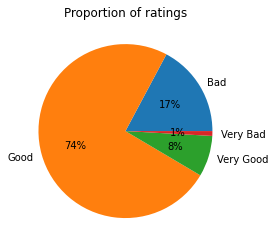

In [12]:
labels = new_data['RatingClass']
plot_df = count_data(new_data, labels)

n = plt.pie(x = plot_df.Count, labels = plot_df.Labels, autopct='%.0f%%')
n=plt.title('Proportion of ratings')

### Data visualization con data aumentado

In [13]:
#This is a function in order to have an aproximation of the rating, by th class it is using for the plots.
X_r2['RatingClass'] = y_r2

def rating_average(val):
  
  if val == 'Very Bad':
    return 2.5
  elif val == 'Bad':
    return 4.5
  elif  val == 'Good':
    return 6.5
  elif  val == 'Very Good':
    return 8.5
    
X_r2['averageRating'] = X_r2['RatingClass'].apply(lambda x: rating_average(x))
X_r2.head()

,Year,Duration,FantasySciFi,Animation,Comedy,Family,Romance,ActionWarAdventureWestern,CrimeHorrorMisteryThriller,HistoryDocumentaryBiography,...,SportNews,Drama,RealityTV,PopularActors,PopularDirectors,Budgets,LanguageCat,MonthCat,RatingClass,averageRating
0,2018,108,0,0,1,0,1,0,0,0,...,0,0,0,0,0,332480,6,11,Bad,4.5
1,2019,150,0,0,0,0,0,1,1,0,...,0,0,0,0,0,9237,6,1,Bad,4.5
2,2018,115,0,0,1,1,0,0,0,0,...,0,0,0,0,0,3960475,6,10,Bad,4.5
3,2018,130,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1755,3,11,Bad,4.5
4,2019,82,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1000000,1,4,Bad,4.5


#### Analysis of proportion of ratings

It is the same plot as before but after applying data augmentation techniques.

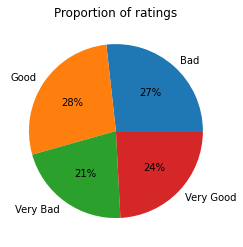

In [14]:
labels = X_r2['RatingClass']
plot_df = count_data(X_r2, labels)

n = plt.pie(x = plot_df.Count, labels = plot_df.Labels, autopct='%.0f%%')
n=plt.title('Proportion of ratings')

#### Release Months

We can observe that there is more or less no great difference between the number of films per month.

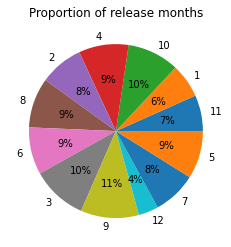

In [15]:
labels = X_r2['MonthCat'].apply(lambda x: int(x))
plot_df = count_data(X_r2, labels, genres = False)

n = plt.pie(x = plot_df.Count, labels = plot_df.Labels, autopct='%.0f%%')
n=plt.title('Proportion of release months')

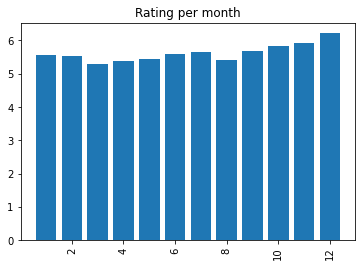

In [16]:
n = plt.bar(plot_df.Labels,plot_df.Avg_rating)
plt.xticks(rotation=90)
n=plt.title('Rating per month')

This plot represents the distribution of the number of observations by class for each month. We can see that very good films (green) tend to be in September and very bad films tend to be in March (red).


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


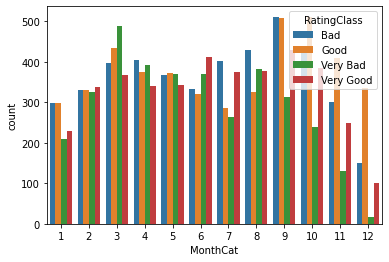

In [18]:
plot = sns.countplot(X_r2.MonthCat, hue=X_r2.RatingClass)
plot = plot.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

#### Languages

In [ ]:
languages_cat_dic = {'0': 'Japanese', '1': 'English', '2': 'French', '3': 'Hindi', '4': 'Spanish', '5': 'Italian', '6': 'Secundarias', '7':'Otros'}
def returnLanguage(lang):
  f = languages_cat_dic[f'{lang}']
  return f
X_r2['Group_Language'] = X_r2['LanguageCat'].apply(lambda x: returnLanguage(x))

If we do the same for languages, we can see that most of them are English movies.

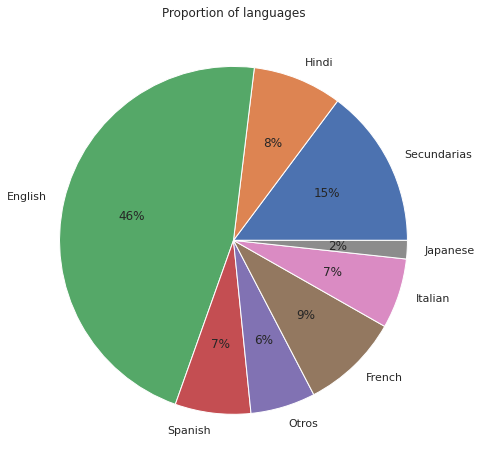

In [ ]:
labels = X_r2['Group_Language']
plot_df = count_data(X_r2, labels, genres = False)

n = plt.pie(x = plot_df.Count, labels = plot_df.Labels, autopct='%.0f%%')
n=plt.title('Proportion of languages')

The movies languages with higher ratings are in Japanese, or from the Other group movie languages.

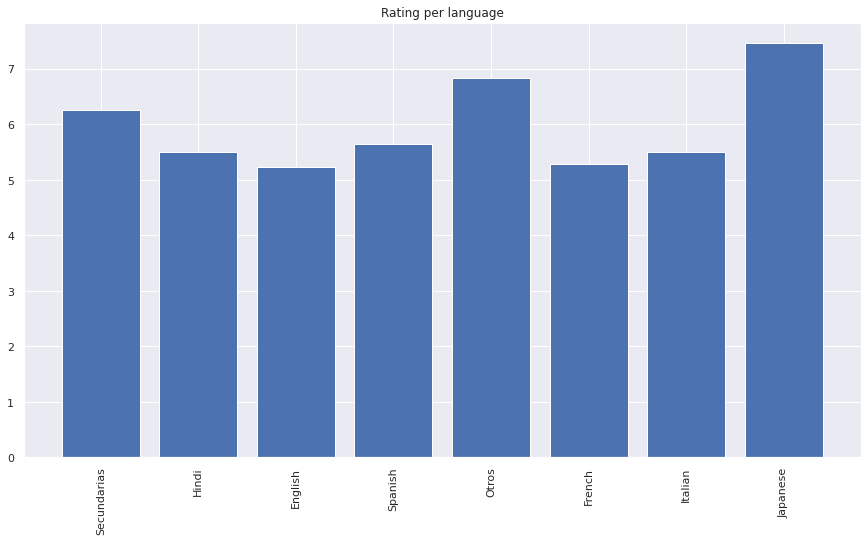

In [ ]:
n = plt.bar(plot_df.Labels,plot_df.Avg_rating)
plt.xticks(rotation=90)
n=plt.title('Rating per language')

 An interesting thing is that most of Eglish movies are ‘bad’. But in the case of the japanese movies, for example, it is the oposite as most of them are ‘good’  or ‘very good’.  

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Japanese'),
 Text(0, 0, 'English'),
 Text(0, 0, 'French'),
 Text(0, 0, 'Hindi'),
 Text(0, 0, 'Spanish'),
 Text(0, 0, 'Italian'),
 Text(0, 0, 'Secundarias'),
 Text(0, 0, 'Otros')]

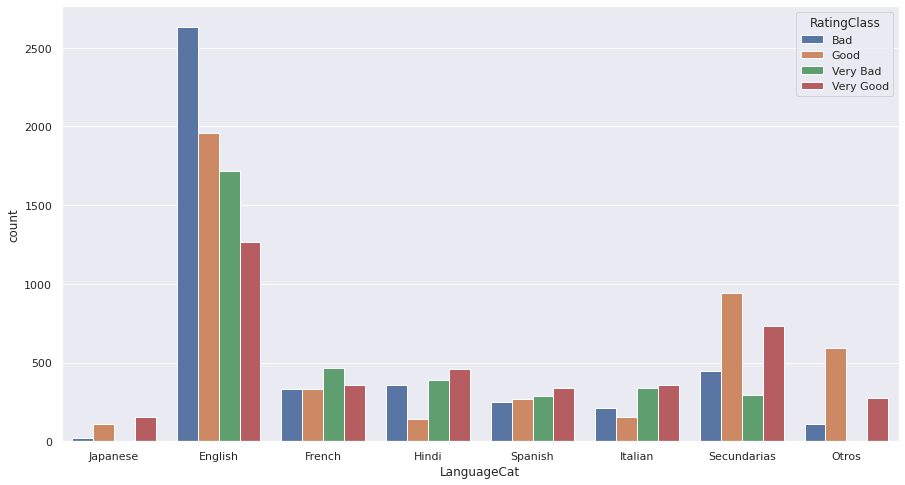

In [ ]:
plot = sns.countplot(X_r2.LanguageCat, hue=X_r2.RatingClass)
plot.set_xticklabels(['Japanese', 'English', 'French', 'Hindi', 'Spanish', 'Italian', 'Secundarias', 'Otros'])

#### Genres

In the genre distribution we can observe that there are some principal genres: Drama, CrimeHorrorMisteryThriller, Comedy and ActionWarAdventureWestern. 

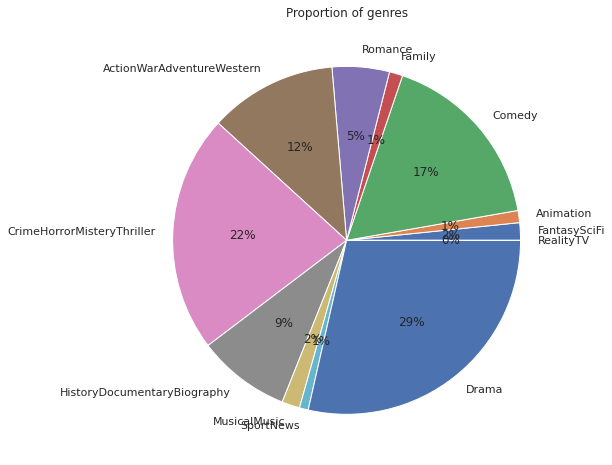

In [ ]:
labels = ['FantasySciFi', 'Animation', 'Comedy', 'Family', 'Romance',
       'ActionWarAdventureWestern', 'CrimeHorrorMisteryThriller',
       'HistoryDocumentaryBiography', 'MusicalMusic', 'SportNews', 'Drama', 'RealityTV']

plot_df = count_data(X_r2, labels, genres = True)

n = plt.pie(x = plot_df.Count, labels = plot_df.Labels, autopct='%.0f%%')
n=plt.title('Proportion of genres')

Even though the genre distribution, some of the genres ith higher ratings are HistorydocumentaryBiography, MusicMusical, SportNews, Drama and Animation.

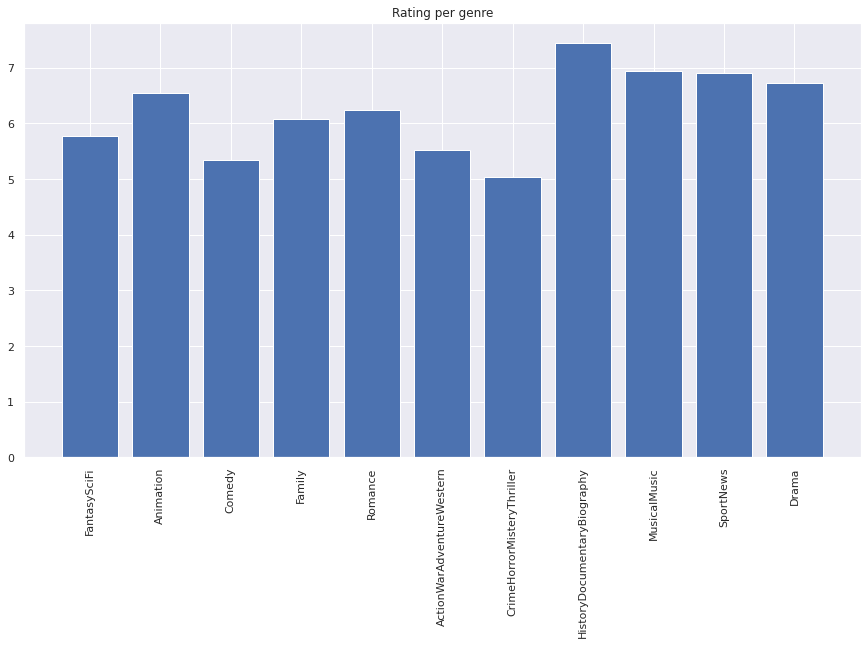

In [ ]:
n = plt.bar(plot_df.Labels, plot_df.Avg_rating)
plt.xticks(rotation=90)
n=plt.title('Rating per genre')

#### Duration

In [ ]:
plot_df = X_r2.sort_values('Duration')[['Duration', 'averageRating', 'RatingClass']]
plot_df = plot_df.groupby('Duration')[['averageRating', 'RatingClass']].mean().reset_index()

If we study the average rating of movies as the duration increases, we can see that long movies tend to have high ratings.

Text(0.5, 1.0, 'Rating by duration')

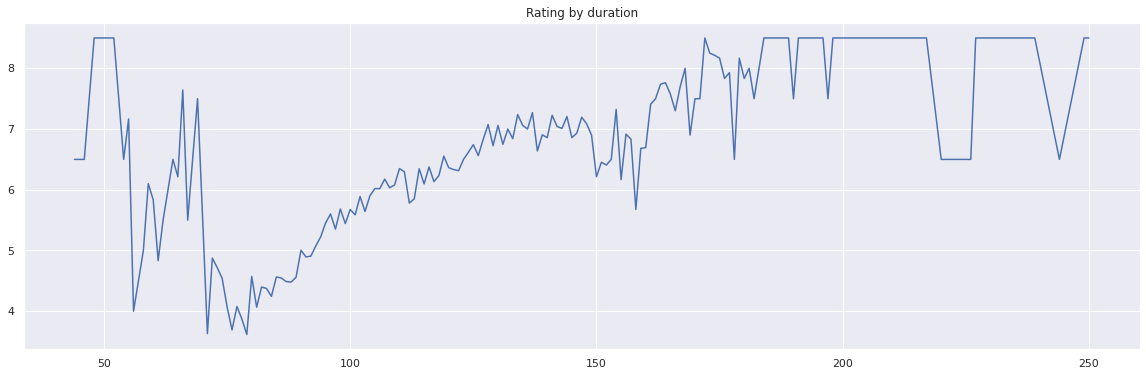

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(plot_df.Duration, plot_df.averageRating)
plt.title('Rating by duration')

We can observe at the boxplot the movies for the class ‘Very Good’ have an average duration of 2 hours, while the others have lower average durations.


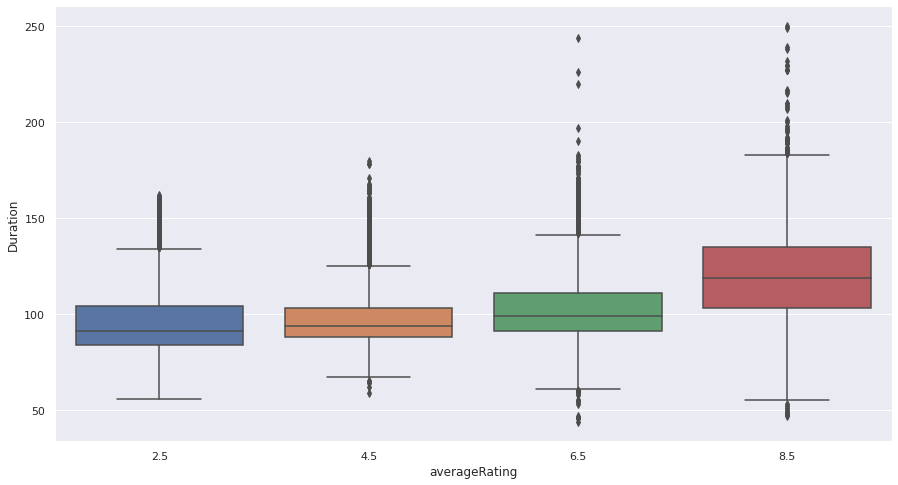

In [ ]:
sns.boxplot(x=X_r2.averageRating, y=X_r2.Duration)

#### Years

In [19]:
plot_df = X_r2[['MonthCat', 'Year', 'averageRating']]
plot_df.MonthCat = plot_df.MonthCat.apply(lambda x: str(round(x)))
plot_df.Year = plot_df.Year.apply(lambda x: str(x))
plot_df['Year-Month'] = plot_df.MonthCat + '-' + plot_df.Year

plot_df.MonthCat = plot_df.MonthCat.apply(lambda x: int(x))
plot_df.Year = plot_df.Year.apply(lambda x: int(x))
plot_df = plot_df.groupby(['Year-Month', 'MonthCat', 'Year'])[['averageRating']].mean().reset_index()
plot_df = plot_df.sort_values(['Year','MonthCat'])[['Year-Month', 'averageRating','MonthCat', 'Year' ]]

plot_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-19-b2e03c4e36ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Year-Month'] = plot_df.MonthCat + '-' + plot_df.Year


,Year-Month,averageRating,MonthCat,Year
93,5-2002,6.5,5,2002
40,12-2005,6.5,12,2005
121,7-2006,6.5,7,2006
41,12-2006,6.5,12,2006
79,4-2007,6.5,4,2007


If we do the same as before but along time, we can see that ratings remain fairly stable over the years. In addition, we can observe that there has been a slight increase in movie ratings for the last year, and that in 2012, there were some 'bad' rating movies.

Text(0.5, 1.0, 'Rating throughout time')

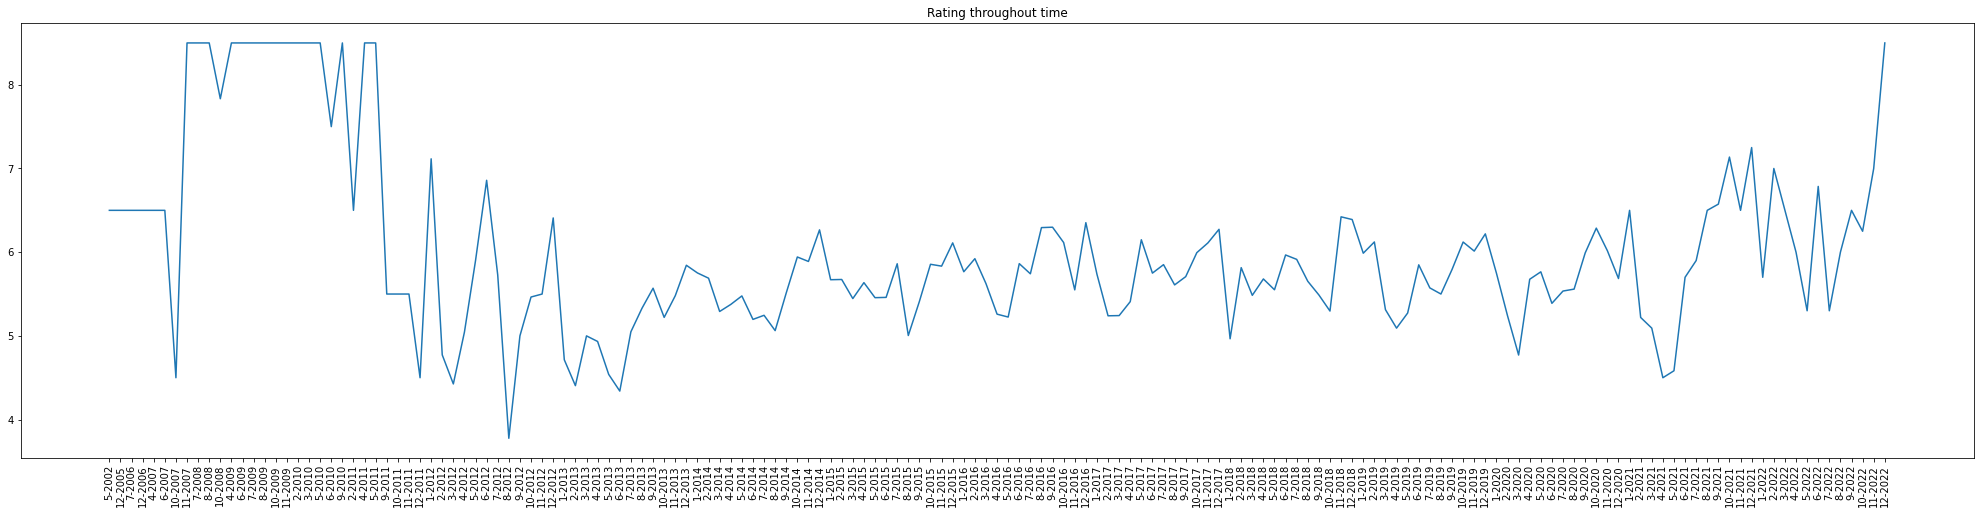

In [20]:
plt.figure(figsize=(35,8))
plt.plot(plot_df['Year-Month'], plot_df.averageRating)
n = plt.xticks(rotation=90)
plt.title('Rating throughout time')